In [1]:
# imports
import sys
sys.path.append( '..' )

from FIA.FIA import *
from ML.ML4com import *
from plot import *

In [9]:
run = "latent" # annot
run_dir = f"/mnt/d/runs/ML/{run}"
report_dir = f"/mnt/d/reports/ML"

source = "Com8_grown_together"
recon_loss = "mae_2"
project = f"{source}_{recon_loss}" if run.endswith("latent") else source

algorithms = ["Decision tree", "Extreme gradient boosting RF", "Gaussian Naive-Bayes", "K-neighbours classifier", "Linear Discriminant Analysis",
              "Logistic Regression", "Neural Network (MLP) SK-learn", "Random forest", "Support-vector classifier"]

## Mock data

In [3]:
conf_matrices = np.array([[[10, 1], [9, 2]], [[5, 5], [6, 4]], [[0, 0], [0, 1]]])
accuracies = np.array([[1.0, 0.98, 0.77, 0.82, 0.99], [1.0, 0.98, 0.77, 1.0, 0.69], [0.1, 0.23, 0.98, 0.27, 0.74]])

In [4]:
# PLOTTING
def plot_cv_confmat(ys, target_labels, accuracies, confusion_matrices, outdir, name):
    """
    Plot heatmap of confusion matrix
    """
    warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect*")
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 8))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])          # type: ignore
    for i, ax in enumerate(axs.flat):
        sns.heatmap(confusion_matrices[i], 
                    vmin=0, vmax=len(ys), annot=True, ax=ax, 
                    cbar=i == 0, cbar_ax=None if i else cbar_ax)
        ax.set_title(f'{target_labels[i]}, Accuracy: {round(accuracies[i], 5)}')
        ax.axis('off')
    fig.tight_layout(rect=[0, 0, .9, 1])                # type: ignore
    plt.savefig(os.path.join(outdir, f"{name}.png"))
    plt.close()

## Plots

### Heatmaps

<Axes: >

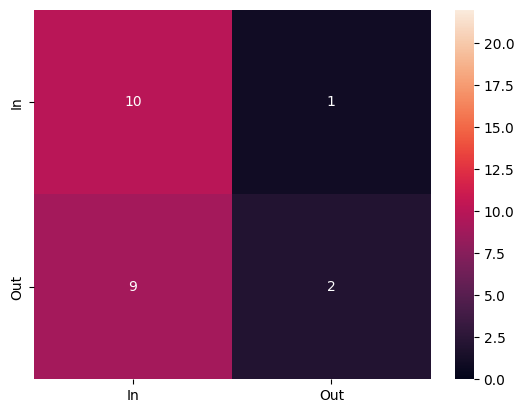

In [5]:
# Confusion matrix
plot_df = pd.DataFrame(conf_matrices[0], columns=["In", "Out"], index=["In", "Out"])
sns.heatmap(plot_df, vmin=0, vmax=np.sum(conf_matrices[0]), annot=True)

<Axes: xlabel='Cross-Validation run', ylabel='Organisms'>

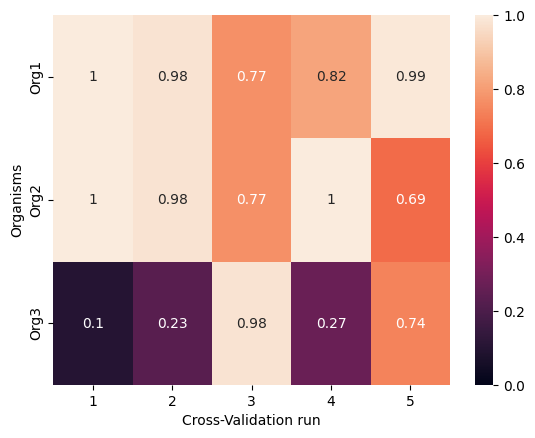

In [6]:
# Accuracy CV matrix
plot_df = pd.DataFrame(accuracies, columns=[1, 2, 3, 4, 5], index=["Org1", "Org2", "Org3"])
plot_df.index.name = "Organisms"
plot_df.columns.name = "Cross-Validation run"
sns.heatmap(plot_df, vmin=0, vmax=1.0, annot=True)

In [7]:
exp = load_experiment("../../data/comm8_self/converted/msAV206_P3A1_neg.mzML")
sns.set_theme(rc={"figure.figsize":(12, 4)})
ax = sns.lineplot(pd.DataFrame(np.array(exp[0].get_peaks()).T, columns=["m/z", "intensity"]), x="m/z", y="intensity")

RuntimeError: the file '../../data/comm8_self/converted/msAV206_P3A1_neg.mzML' could not be found

In [129]:
def add_methodology(df, dim_red_method:str, classification_algorithm:str):
    df["Dimensionality reduction method"] = pd.Series([dim_red_method]*len(df))
    df["Classificaton algorithm"] = pd.Series([classification_algorithm]*len(df))
    return df

## Inference comparison

In [130]:
algorithms = ["decision tree", "Random forest","Gaussian Naive-Bayes"]

dfs = []
for dim_red_method, dr_path in {"Latent space - Cosine": "latent/vae_tensorflow_cpu_cos"}.items():
    for algorithm in algorithms:
        path = os.path.join("/mnt/d/runs/ML/", dr_path, f"{algorithm}_metrics.tsv")
        dfs.append(add_methodology( pd.read_csv( path, sep="\t", index_col=0),
                                    dim_red_method=dim_red_method, classification_algorithm=algorithm))

In [131]:
pd.concat( dfs )

,Organism,Cross-Validation run,Accuracy,AUC,TPR,FPR,Threshold,Conf_Mat,Dimensionality reduction method,Classificaton algorithm
0,C. ramosum,1,0.500000,0.477778,[0. 0.55555556 1. ],[0. 0.6 1. ],[inf 1. 0.],[[2 3]\n [4 5]],Latent space - Cosine,decision tree
1,C. ramosum,2,0.642857,0.500000,[0. 1.],[0. 1.],[inf 1.],[[0 5]\n [0 9]],Latent space - Cosine,decision tree
2,C. ramosum,3,0.642857,0.633333,[0. 0.66666667 1. ],[0. 0.4 1. ],[inf 1. 0.],[[3 2]\n [3 6]],Latent space - Cosine,decision tree
3,C. ramosum,4,0.692308,0.675000,[0. 0.75 1. ],[0. 0.4 1. ],[inf 1. 0.],[[3 2]\n [2 6]],Latent space - Cosine,decision tree
4,C. ramosum,5,0.461538,0.450000,[0. 0.5 1. ],[0. 0.6 1. ],[inf 1. 0.],[[2 3]\n [4 4]],Latent space - Cosine,decision tree
...,...,...,...,...,...,...,...,...,...,...
35,R. intestinalis,1,0.642857,0.722222,[0. 0.44444444 1. ],[0. 0. 1.],[inf 1. 0.],[[5 0]\n [5 4]],Latent space - Cosine,Gaussian Naive-Bayes
36,R. intestinalis,2,0.285714,0.355556,[0. 0.11111111 1. ],[0. 0.4 1. ],[inf 1. 0.],[[3 2]\n [8 1]],Latent space - Cosine,Gaussian Naive-Bayes
37,R. intestinalis,3,0.357143,0.455556,[0. 0.11111111 1. ],[0. 0.2 1. ],[inf 1. 0.],[[4 1]\n [8 1]],Latent space - Cosine,Gaussian Naive-Bayes
38,R. intestinalis,4,0.307692,0.400000,[0. 0. 1.],[0. 0.2 1. ],[inf 1. 0.],[[4 1]\n [8 0]],Latent space - Cosine,Gaussian Naive-Bayes


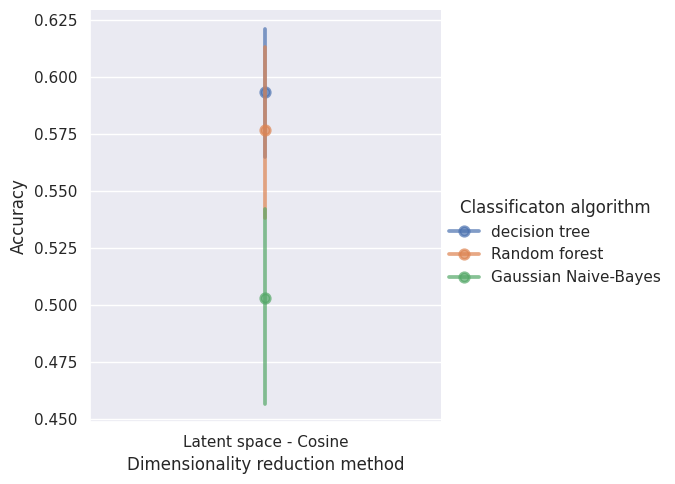

In [132]:
ax = sns.catplot(
    data=pd.concat( dfs ), x="Dimensionality reduction method", y="Accuracy", hue="Classificaton algorithm", kind="point", alpha=0.7
)